# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd #импортируем панды для создания датафреймов
import numpy as np
from pymystem3 import Mystem #импортируем библиотеку для будущей работы с лемматизацией, пригодится
m = Mystem()

In [2]:
data = pd.read_csv('/datasets/data.csv') #загружаем датасет, записываем в переменную data
data.head(10) #смотрим 10 первых строк, как открылось, какие названия колонок, кодировка и т.д

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [4]:
data.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


Посмотрим на содержания униикальных значений в каждой колонке

In [5]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

In [6]:
data[data['children'] == -1].shape

(47, 12)

In [7]:
data[data['children'] == 20].shape

(76, 12)

в children есть странное значение -1, которое надо будет удалить, похоже на опечатку. в 20 тыс значений 47 шт. это 1/4 процента. Можно подумать что сделать с ними. 20 - тоже могут возникнуть вопросы, но мы не знаем, может это усыновленные дети?

In [8]:
data['days_employed'].nunique()

19351

In [9]:
data['days_employed'].sort_values() #проверяю что тут NaN, а не None0

16335   -18388.949901
4299    -17615.563266
7329    -16593.472817
17838   -16264.699501
16825   -16119.687737
             ...     
21489             NaN
21495             NaN
21497             NaN
21502             NaN
21510             NaN
Name: days_employed, Length: 21525, dtype: float64

In [10]:
display(data['days_employed'].max())
display(data['days_employed'].min())

401755.40047533

-18388.949900568383

посмотрим на значения трудового стажа, сразу возникает вопрос к 401755 дням, это 1100 лет. поэтому надо вообще посмотреть, откуда закрались такие данные и как их много.

In [11]:
%matplotlib inline

In [12]:
median_column = data['days_employed']

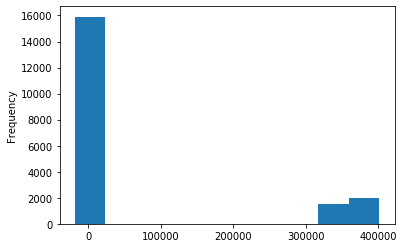

In [13]:
median_column.plot(kind="hist")

как видно на графике, есть бОльшая часть значений лежит в разумных пределах, но есть и такие данные - дни работы, которые аж за 300000, и их не 1 и 2, а больше 3000. Есть подозрение, что там не дни работы, а часы. попробуем узнать.

In [14]:
(data['days_employed'].max() / 365) / 24 

45.8624886387363

тут проверяю гипотизу, что в максимальных данных есть ошибка, это часы, а не дни! и проверив делением на 24, получаем в максимальном значении - 45 лет, что вполне разумно. отсюда вывод - данные, которые в правой части графика - их будем дополнительно делить на 24, чтобы получить данные годах.

в days_employed много различных значений.

In [15]:
data['dob_years'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75])

In [16]:
data[data['dob_years'] == 0].shape

(101, 12)

в dob_years странное значене "0", 101 значение в датафрейме, можно заменить на медианное значение возраста

In [17]:
data['education_id'].unique()

array([0, 1, 2, 3, 4])

In [18]:
data[data['education_id'] == 3].head(5) #посмотрим соответствие education_id = 3

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
31,0,-1682.083438,47,начальное,3,женат / замужем,0,F,сотрудник,0,275485.684538,жилье
136,0,357880.159379,60,начальное,3,женат / замужем,0,M,пенсионер,0,113124.202781,операции со своей недвижимостью
210,2,342167.212112,55,начальное,3,вдовец / вдова,2,F,пенсионер,0,160635.120347,строительство жилой недвижимости
211,0,-577.273434,41,начальное,3,гражданский брак,1,F,сотрудник,0,36649.078439,сделка с подержанным автомобилем
272,0,-5538.963731,35,начальное,3,гражданский брак,1,M,сотрудник,1,123814.079468,заняться образованием


похожа колонка на education, и соответствие высшее - 0, среднее - 1, неоконченное высшее - 2, начальное - 3, ученая степень - 4

In [19]:
data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

в education нужно привести все к одному регистру, и потом чистить дубликаты

In [20]:
data['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

In [21]:
data['family_status_id'].unique()

array([0, 1, 2, 3, 4])

опять посмотрим соответсвтиея id и статуса: 'женат / замужем' - 0, 'гражданский брак' - 1, 'вдовец / вдова' - 2,  в разводе	 - 3, 'Не женат / не замужем' - 4

In [22]:
data['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

Пол указан и не указан, тоже люди могли не указывать.

In [23]:
data['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

все ок

In [24]:
data['debt'].unique()

array([0, 1])

тоже все понятно, была просрочка или нет

In [25]:
display(data['total_income'].max())
display(data['total_income'].min())

2265604.028722744

20667.26379327158

In [26]:
median_column_income = data['total_income']

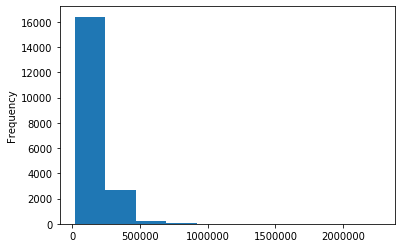

In [27]:
median_column_income.plot(kind="hist")

в колонке дохода можно проверить цифры на выбросы и адекватность, и в принципе все нормально, реальные значения

In [28]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

одна из самых инетерсных колонок. нужно будет выделить на группы с помощью лемматизации, на "жилье", "свадьба", "авто", "образование"

**Вывод**

Названия колонок в правильном виде, можно и не менять. Анализируя тип данных и пропуски, мы видим, что days_employed и total_income имеют пропуски. Я думаю, что это человеческий фактор, т.к. при заполнении данных люди могли эти строчки не заполнять. Бросается в глаза, что в days_employed есть знак минус в трудовом стаже и тип данных - float64 . тк дни это целочисленные данные, то можно привести в int64, эти пункты надо будет поправить. По каждому пункту я прошелся, выделил что надо сделать и будем это делать в следующем шаге. 

## Шаг 2. Предобработка данных

### Обработка пропусков

Уберем крайние значения -1 и 20 детей в колонке 'children', т.к. их всего 120 строчек на 20000, их потеря не повлияет на общую картину

In [29]:
data = data.loc[~data['children'].isin([-1,20])] #удалили строки с количеством детей -1 и 20

In [30]:
data.info() #уменьшилось количество общих строчек, проверка

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21402 entries, 0 to 21524
Data columns (total 12 columns):
children            21402 non-null int64
days_employed       19240 non-null float64
dob_years           21402 non-null int64
education           21402 non-null object
education_id        21402 non-null int64
family_status       21402 non-null object
family_status_id    21402 non-null int64
gender              21402 non-null object
income_type         21402 non-null object
debt                21402 non-null int64
total_income        19240 non-null float64
purpose             21402 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


Работаем с days_employed, сначала возьмем все значения по модулю, потом у части значений > 300000 поделим на 24, чтобы перевести из часов в дни, и напоследок заполним пропущенные значения медианой значений по столбцу days_employed

In [31]:
data['days_employed'] = data['days_employed'].abs()

In [32]:
data['days_employed'].describe() #смотрим, что нет отрицательных значений в days_employed

count     19240.000000
mean      67027.691459
std      139130.846446
min          24.141633
25%         927.984311
50%        2195.251592
75%        5556.372075
max      401755.400475
Name: days_employed, dtype: float64

In [33]:
data[data['days_employed'] > 300000].count()

children            3431
days_employed       3431
dob_years           3431
education           3431
education_id        3431
family_status       3431
family_status_id    3431
gender              3431
income_type         3431
debt                3431
total_income        3431
purpose             3431
dtype: int64

In [34]:
data['days_employed'][(19000 <= data['days_employed']) & (data['days_employed'] < 300000)].count() 
#проверили, что нет значений в диапазоне от 19000 до 300000, все что больше, это уже косяк с часами

0

In [35]:
data.loc[data['days_employed'] > 19000, 'days_employed'] = data.loc[data['days_employed'] > 19000, 'days_employed'] / 24
#перевели часть значений из часы в дни

In [36]:
data.isna().sum() #смотрим  сколько NaN

children               0
days_employed       2162
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2162
purpose                0
dtype: int64

In [37]:
data['days_employed'].fillna(value=data['days_employed'].mean(), inplace=True)

In [38]:
data.isna().sum()

children               0
days_employed          0
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2162
purpose                0
dtype: int64

Заменим значения с 0 на медиану значений по столбцу 'dob_years' возраст заёмщика

In [39]:
data[data['dob_years'] == 0].count() #проверяем количество значений

children            100
days_employed       100
dob_years           100
education           100
education_id        100
family_status       100
family_status_id    100
gender              100
income_type         100
debt                100
total_income         90
purpose             100
dtype: int64

In [40]:
mean_dob_years = data['dob_years'].mean(skipna=True).astype('int64') # + меняем тип данных на int
mean_dob_years #находим медианное значение возраста

43

In [41]:
data.loc[data.dob_years == 0, 'dob_years'] = mean_dob_years #заменяем значения, где ноль на медиану 43

In [42]:
data[data['dob_years'] == 0].count() #проверяем выполенения результата

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

приводим в education все названия к нижнему регистру

In [43]:
data['education'] = data['education'].str.lower()

In [44]:
data['education'].unique() #проверяем отработку

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

total_income заменяем на медиану значений

In [45]:
data['total_income'].fillna(value=data['total_income'].mean(), inplace=True)

In [46]:
data.isna().sum() #проверяем NaN больше нет

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

**Вывод**: мы заменили пропущенные значения медианными по колонкам, + удалили вбросы

### Замена типа данных

Тип данных можно заменить в days_employed  и  total_income  с float64 на int64, т.к. дни работы и уровень дохода можно брать целочислено, без знаков после запятой

In [47]:
data['days_employed'] = data['days_employed'].astype(int)

In [48]:
data['total_income'] = data['total_income'].astype(int)

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21402 entries, 0 to 21524
Data columns (total 12 columns):
children            21402 non-null int64
days_employed       21402 non-null int64
dob_years           21402 non-null int64
education           21402 non-null object
education_id        21402 non-null int64
family_status       21402 non-null object
family_status_id    21402 non-null int64
gender              21402 non-null object
income_type         21402 non-null object
debt                21402 non-null int64
total_income        21402 non-null int64
purpose             21402 non-null object
dtypes: int64(7), object(5)
memory usage: 2.1+ MB


**Вывод**: типы данных изменены

### Обработка дубликатов

In [50]:
data.duplicated().sum()
# подсчёт явных дубликатов

71

In [51]:
data = data.drop_duplicates().reset_index(drop=True)
# удаление явных дубликатов (с удалением старых индексов и формированием новых)

In [52]:
data.duplicated().sum() #проверка удалились ли дубликаты

0

**Вывод**: дубликаты могли появиться в следствии того, что привели названия education к нижнему регистру и могли задвоиться данные.

### Лемматизация и категоризация

In [53]:
purpose_list = data['purpose'].unique() #выделяем цели получения кредита

In [54]:
#Создадим функцию, которая позволит задать группы целей получения кредита
def get_purpose_group(purpose):
    lemma = m.lemmatize(purpose)
    if 'автомобиль' in lemma:
        return 'авто'
    elif ('строительство' in lemma) or ('ремонт' in lemma):
        return 'стройка и ремонт'
    elif 'образование' in lemma:
        return 'учеба'
    elif 'свадьба' in lemma:
        return 'свадьба'
    elif ('жилье' in lemma) or ('недвижимость' in lemma):
        return 'недвижимость'
    else:
        return 'другое'

In [55]:
#Cоздадим словарь групп категорий
purpose_dict = {}
for row in purpose_list:
    purpose_dict[row] = get_purpose_group(row)


In [56]:
#Создадим новый столбец с группой получения кредита и передадим словарик
for index in range(len(data)):
    data.loc[index, 'purpose_group'] = purpose_dict.get(data.loc[index, 'purpose'])

Добавим категоризацю по уровню дохода. Разделим на 4 группы: низкий - до 50000., средний - от 50000 до 100000, высокий от 100000 до 500000, и сверхвысокий от 500000

In [57]:
def income_group(total_income):
    """
    Возвращает группу по уровню дохода, используя правила:
    - 'низкий', если total_income <= 50000;
    - 'средний', если total_income более 50000 и менее 100000
    - 'высокий', если total_income более 100000 и менее 500000
    - 'сверхвысокий', если total_income более 500000
    """
    
    if total_income <= 50000:
        return 'низкий'
    if total_income <= 100000:
        return 'средний'
    if total_income <= 500000:
        return 'высокий'
    return 'сверхвысокий' 

In [58]:
data['income_group'] = data['total_income'].apply(income_group) #добавим новую колонку в датафрей, применяя функцию

In [59]:
data[data['income_group'] == 'сверхвысокий'].head(5) 
#проверяем, нормально ли отрабатывет функция, проверив все категории смотрим на total_income

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_group,income_group
39,0,650,31,высшее,0,гражданский брак,1,F,компаньон,0,754240,заняться образованием,учеба,сверхвысокий
68,2,2152,46,высшее,0,женат / замужем,0,M,компаньон,0,592071,операции с коммерческой недвижимостью,недвижимость,сверхвысокий
364,2,1372,36,высшее,0,женат / замужем,0,M,компаньон,0,553624,покупка жилой недвижимости,недвижимость,сверхвысокий
378,0,7115,50,среднее,1,женат / замужем,0,F,сотрудник,1,506773,жилье,недвижимость,сверхвысокий
683,0,1839,52,среднее,1,в разводе,3,F,сотрудник,0,536888,высшее образование,учеба,сверхвысокий


**Вывод**: мы провели группировку по целям кредита и уровнем дохода на большие группы и теперь можем отвечать на главные вопросы.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [60]:
# сгруппируем таблицу по признаку задолженности и по количеству детей
data_sorted_children = data.groupby(['children', 'debt']).agg({'debt':'count'})
# посмотрим на отсотированный датафрейм
data_sorted_children

debt
children debt       
0        0     13028
         1      1063
1        0      4364
         1       444
2        0      1858
         1       194
3        0       303
         1        27
4        0        37
         1         4
5        0         9

In [61]:
# рассчитаем % по типу наличия задолженности от общего количества кредитов по категории family_status
data_sorted_children['percentage_%'] = (data_sorted_children['debt']/
                                   (data_sorted_children.groupby('children')['debt'].transform('sum')))*100

data_sorted_children

debt  percentage_%
children debt                     
0        0     13028     92.456178
         1      1063      7.543822
1        0      4364     90.765391
         1       444      9.234609
2        0      1858     90.545809
         1       194      9.454191
3        0       303     91.818182
         1        27      8.181818
4        0        37     90.243902
         1         4      9.756098
5        0         9    100.000000

**Вывод**: мы можем увидеть, что заемщики без детей лучше возвращают кредиты, т.к. % невозврата меньше в среднем на 2% 

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [62]:
# сгруппируем таблицу по признаку задолженности и типу семейному статусу
data_sorted_family = data.groupby(['family_status', 'debt']).agg({'debt':'count'})
# посмотрим на отсотированный датафрейм
data_sorted_family

debt
family_status         debt       
Не женат / не замужем 0      2523
                      1       273
в разводе             0      1105
                      1        84
вдовец / вдова        0       888
                      1        63
гражданский брак      0      3749
                      1       385
женат / замужем       0     11334
                      1       927

In [63]:
# рассчитаем % по типу наличия задолженности от общего количества кредитов по категории family_status
data_sorted_family['percentage_%'] = (data_sorted_family['debt']/
                                   (data_sorted_family.groupby('family_status')['debt'].transform('sum')))*100

data_sorted_family

debt  percentage_%
family_status         debt                     
Не женат / не замужем 0      2523     90.236052
                      1       273      9.763948
в разводе             0      1105     92.935240
                      1        84      7.064760
вдовец / вдова        0       888     93.375394
                      1        63      6.624606
гражданский брак      0      3749     90.686986
                      1       385      9.313014
женат / замужем       0     11334     92.439442
                      1       927      7.560558

**Вывод**: мы видим, что процент просрочки кредита разный в зависимости от семейного статуса: Не женат / не замужем - 9,76; в разводе - 7.06; вдовец / вдова - 6,62; гражданский брак - 9,3; женат / замужем - 7,56. О чем можно сдлетать вывод, что официально расписанные супруги лучше возвращают кредиты в срок.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [64]:
# сгруппируем таблицу по признаку задолженности и уровнем дохода
data_sorted_income = data.groupby(['income_group', 'debt']).agg({'debt':'count'})
# посмотрим на отсотированный датафрейм
data_sorted_income

debt
income_group debt       
высокий      0     15301
             1      1364
низкий       0       348
             1        23
сверхвысокий 0       208
             1        14
средний      0      3742
             1       331

In [65]:
# рассчитаем % по типу наличия задолженности от общего количества кредитов по категории income_group
data_sorted_income['percentage_%'] = (data_sorted_income['debt']/
                                   (data_sorted_income.groupby('income_group')['debt'].transform('sum')))*100

data_sorted_income

debt  percentage_%
income_group debt                     
высокий      0     15301     91.815182
             1      1364      8.184818
низкий       0       348     93.800539
             1        23      6.199461
сверхвысокий 0       208     93.693694
             1        14      6.306306
средний      0      3742     91.873312
             1       331      8.126688

**Вывод**: люди с низким (до 50000 в мес) и сверхвысоким (более 500000 в мес) достатком лучше возвращают кредиты, чем с выским и средним достатком.

- Как разные цели кредита влияют на его возврат в срок?

In [66]:
# сгруппируем таблицу по признаку задолженности и целям кредита
data_sorted_purpose = data.groupby(['purpose_group', 'debt']).agg({'debt':'count'})
# посмотрим на отсотированный датафрейм
data_sorted_purpose

debt
purpose_group    debt      
авто             0     3879
                 1      400
недвижимость     0     7678
                 1      602
свадьба          0     2130
                 1      183
стройка и ремонт 0     2293
                 1      178
учеба            0     3619
                 1      369

In [67]:
# рассчитаем % по типу наличия задолженности от общего количества кредитов по категории family_status
data_sorted_purpose['percentage_%'] = (data_sorted_purpose['debt']/
                                   (data_sorted_purpose.groupby('purpose_group')['debt'].transform('sum')))*100

data_sorted_purpose

debt  percentage_%
purpose_group    debt                    
авто             0     3879     90.652022
                 1      400      9.347978
недвижимость     0     7678     92.729469
                 1      602      7.270531
свадьба          0     2130     92.088197
                 1      183      7.911803
стройка и ремонт 0     2293     92.796439
                 1      178      7.203561
учеба            0     3619     90.747242
                 1      369      9.252758

**Вывод**: на недвижимость, стройку и ремонт и свадьбу возвращают лучше, чем на учебу и автомобили.

## Шаг 4. Общий вывод

Проанализировав разные группы заемщиков можно выделять определенные группы и делать определенное ранжирование. Так, например, для банка будет лучше всего, чтобы % просрочки по возврату был минимальный. И поэтому портрет "идеального" заемщика: "Без детей, женат/замужем, низкий или сверхвысокий достаток и цели кредита: стройка или покупка недвижимости"